In [1]:
#dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct

### Trip Dates

In [2]:
#choose a start and end date for the trip
trip_start = dt.date(2018,7,3)
trip_end = dt.date(2018,7,17)

In [3]:
#create the engine
engine = create_engine('sqlite:///Resources/hawaii.sqlite')

In [4]:
#reflect an the db into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

#look at the table names
Base.classes.keys()

['Measurements', 'Stations']

In [6]:
#make references to the tables
msmt = Base.classes.Measurements
stn = Base.classes.Stations

In [7]:
#create a session
session = Session(engine)

### Precipitation Analysis

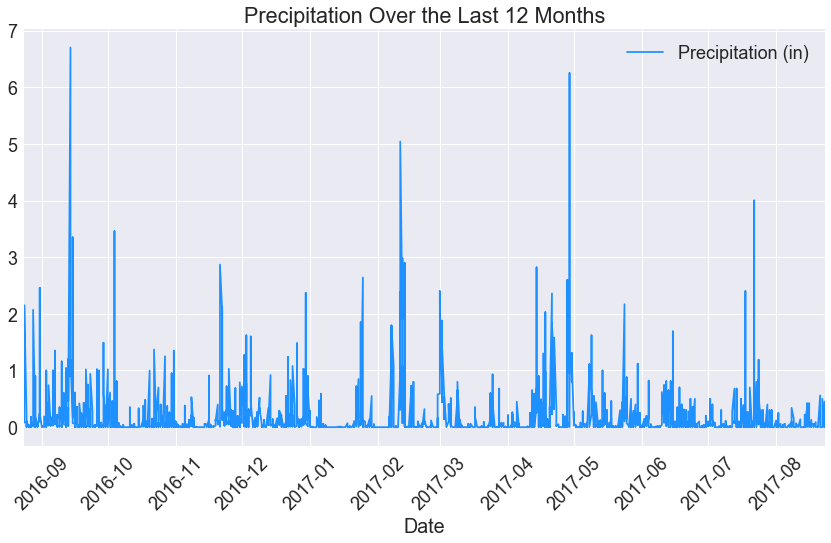

In [8]:
'''Query Last 12 Months of Precip Data'''

#find the most recent date in the db
most_recent = session.query(func.max(msmt.date)).scalar()

#subtract a year from it
year = dt.timedelta(days=365)
year_ago =  most_recent - year

#select only the date and prcp values
yr_prcp = session.query(msmt.date, msmt.prcp).filter(msmt.date > year_ago ).all()

#load the query results into a df 
yr_prcp_df = pd.DataFrame(yr_prcp, columns=['Date', 'Precipitation (in)'])

#set the index to the date column
yr_prcp_df.set_index('Date', inplace=True)

'''Plot the Results'''

#make the font scale larger
sns.set(font_scale=1.8)

#plot making the figure size larger and supress the automatic tick resolution adjustment 
yr_prcp_df.plot(figsize=(12, 8), x_compat=True, color='dodgerblue')

#set the title
plt.title('Precipitation Over the Last 12 Months')
          
#rotate the x labels 45 degrees
plt.xticks(rotation='45')

#make it a tight layout
plt.tight_layout()

plt.show()

In [9]:
#show the summary statistics for the precipitation data
yr_prcp_df.describe()

,Precipitation (in)
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [10]:
'''Calculate the rainfall per weather station using the previous year's matching dates'''

#find the matching dates from the previous year 
prv_start = trip_start - year
prv_end = trip_end - year

#make the query
prcp_stn = session.query(msmt.station, msmt.prcp).filter(msmt.date >= prv_start).\
                        filter(msmt.date <= prv_end).group_by(msmt.station).all()

#make the df    
prcp_stn_df = pd.DataFrame(prcp_stn, columns = ['Station', 'Precipitation Totals'])
prcp_stn_df

,Station,Precipitation Totals
0,USC00513117,0.12
1,USC00514830,0.16
2,USC00516128,0.39
3,USC00519281,0.21
4,USC00519397,0.03
5,USC00519523,0.00


### Station Analysis

In [11]:
#design a query to calculate the total number of stations
total_stns = session.query(func.count(distinct(stn.station))).scalar()
print(f'There are {total_stns} stations.')

There are 9 stations.


In [12]:
'''Design a query to find the most active stations'''

#list the stations and observation counts in descending order
actv_stns = session.query(msmt.station, func.count(msmt.station)).\
                          group_by(msmt.station).order_by(func.count(msmt.station).\
                          desc()).all()
    
#make the df     
actv_stns_df = pd.DataFrame(actv_stns, columns=['Station', 'Number of Observations'])

#show which station has the highest number of observations
most_obs_stn = actv_stns_df.iloc[0][0]
most_obs = actv_stns_df.iloc[0][1]
print(f'The station {most_obs_stn} has the most observations with {most_obs:,} observations.')

#make station the index
actv_stns_df.set_index('Station', inplace=True)

actv_stns_df

The station USC00519281 has the most observations with 2,772 observations.


,Number of Observations
Station,
USC00519281,2772
USC00513117,2696
USC00519397,2685
USC00519523,2572
USC00516128,2484
USC00514830,1937
USC00511918,1932
USC00517948,683
USC00518838,342


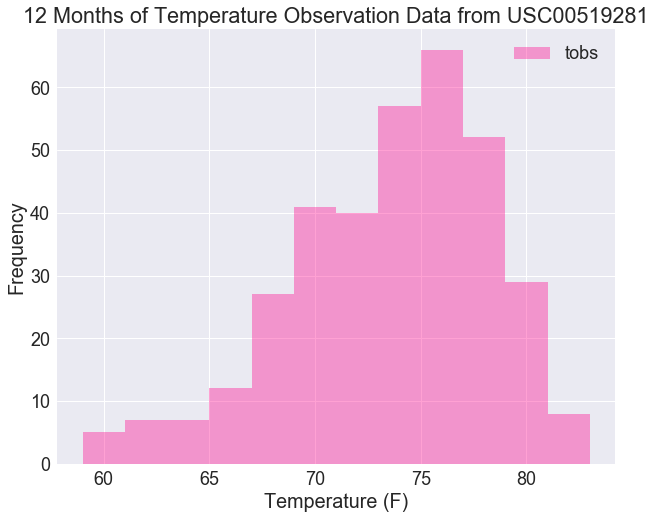

In [13]:
'''Design a query to retrieve the last 12 months of temperature observation data (tobs)'''

#filter by the station with the highest number of observations
yr_tobs = session.query(msmt.tobs).filter(msmt.date > year_ago).filter(msmt.station == most_obs_stn).all()

#make the font scale larger
sns.set(font_scale=1.8)

#set the plot size
plt.figure(figsize=(10,8))

#plot the results as a histogram with bins=12
yr_tobs_hist = sns.distplot(yr_tobs, bins=12, kde=False, axlabel='Temperature (F)', label='tobs', color='deeppink')

#label the y axis
yr_tobs_hist.set(ylabel='Frequency')

#set the title
plt.title(f'12 Months of Temperature Observation Data from {most_obs_stn}')

plt.legend()
plt.show()

### Temperature Analysis

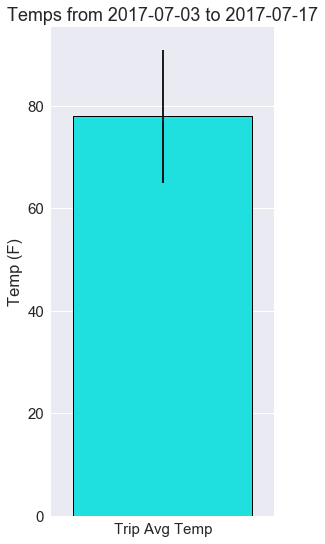

In [14]:
#write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d 
    #and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_dt, end_dt):
    temps = session.query(func.min(msmt.tobs), func.avg(msmt.tobs), func.max(msmt.tobs)).\
                          filter(msmt.date >= start_dt).filter(msmt.date <= end_dt).all()
    
    #pull out the values
    tmp_min, tmp_avg, tmp_max = temps[0]
    
    #return a list
    return [('Trip Min Temp', tmp_min), ('Trip Avg Temp', tmp_avg), ('Trip Max Temp', tmp_max)]

#calculate the min, avg, and max temperatures using the previous year's matching dates 
temps_list = calc_temps(prv_start, prv_end)

#make a df
temps_df = pd.DataFrame(temps_list, columns = ['Title', 'Temp (F)'])

#make sure it's in order
temps_df.sort_values(by=['Temp (F)'])

#calculate the yerr (tmp_max - tmp_min)
max_min = temps_df.iloc[2][1] - temps_df.iloc[0][1]
max_min

'''Plot the min, avg, and max temperature from your previous query as a bar chart'''

#make the font scale larger
sns.set(font_scale=1.5)

#set the plot size
plt.figure(figsize=(4,9))

#plot
sns.barplot(x='Title', y='Temp (F)', data=temps_df.iloc[1:2], color='cyan', 
                  yerr=max_min, edgecolor='k', linewidth=1)

#make the title
plt.title(f'Temps from {prv_start} to {prv_end}')
          

#remove the x label
plt.xlabel('')
plt.show()

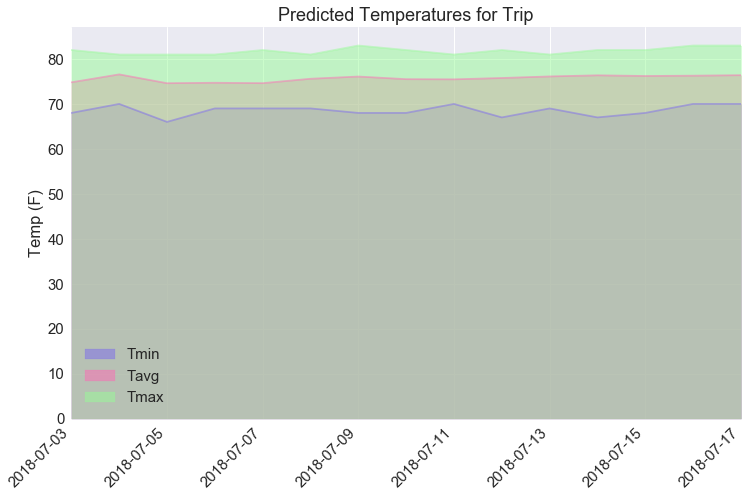

In [15]:
'''Calculate the Daily Normals'''

#create a function called daily_normals that will calculate the daily normals for a specific date
def daily_normals(day_date):
    temps = session.query(func.min(msmt.tobs), func.avg(msmt.tobs), func.max(msmt.tobs)).\
                          filter(func.strftime("%m-%d", msmt.date) == day_date).all()
    return temps
    
#create a list of dates for your trip 
trip_dates = pd.date_range(trip_start, trip_end)

#format it to %m-%d
trip_mmdd = trip_dates.strftime('%m-%d')

#calculate the normals for each date string and append the results to a list
normals_list = []
for trip_date in trip_mmdd:
    #unpack daily_normals
    normals_list.append(*daily_normals(trip_date))

#make a df
normals_df = pd.DataFrame(normals_list, columns = ['Tmin', 'Tavg', 'Tmax'])

#make the trip dates the index
normals_df['Date'] = trip_dates
normals_df = normals_df.set_index('Date')

'''Area Plot'''

#make a colors list
colors = ['mediumslateblue', 'hotpink', 'palegreen']

#make an area plot for the predicted temps
normals_df.plot(kind='area', figsize=(12, 8), stacked=False, x_compat=True, color=colors, title='Predicted Temperatures for Trip', rot=45)

#make the labels
plt.xlabel('')
plt.ylabel('Temp (F)')

plt.show()